# Calibration Chamber--Broken Machine Test_v3


* This pathon notebook is used to determine if the machines tested are in good condition by comparing with the calibration chamber audio. 
* The ideas are: 
 1. Use a *.csv* file (which contains the number of Audiomoth and SD card number) to guide the code to test the machines.
 2. Import the *.wav* audio file directly from the SD card and use UTC_timeDiff to take out the testing time period we want. 
 3. Process the audio file and transform it into a spectrum image in grey form. Then, it will be save in the oringinal folder in a form of *.jpg*. (code from Trieste's provious code)
 4. Functions, *getss* and *getdiff*, calculate the average and variance of a image and resize this image into a square with nxn blocks. Then, the greyness of every block will be prepared with the average of every row to grap the features of evert graph. 
 5. In *comparingfigure* function, 2 images are imported and differences of different images will be shown on a line graph.
 6. This code can detect SD cards in the computer and read them into the program by the order and information shown in *.csv*. 
 7. Mixed with the prvious code calib_v2.(code from Trieste's provious code)
 
### Warning: must ensure no files in the computer contain the same name strings of SD card names. 

* Instructions: 
 1. In the same dictionary of the code, create a *.csv* chart with the info of AM, SD and Notes seperated by comas.
 2. When starting the Audiomoths, record the UTC times (*playback_start*) which is simultaneously recorded into the machines before deploying. 
 3. In *Running all the scripts* chunk, input enter the *playback_start* time. 
 4. In *Calibrate* chunk, input the *.csv* name coresponding to the *playback_start* and the standart audio file path in your computer. (The standart audio file must have the same *playback_start* time with the testing file.)
 5. Input the lenth of time that you want to test in these audio files and input it in the *preprocess--duration* in seconds. 
 6. If you find the start-time of tagart sudio fragment starts a little earlier or later (less than 1s), which can be corrected in *preprocess--delay*. 
 7. If more feature points of the audio files are needed to increase the precision, the number can be adjusted in *getdiff--Sidelength*. 
 


In [36]:
from scipy import signal
from librosa import load
import librosa as lbrs
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from tinytag import TinyTag
import cv2
import matplotlib.pyplot as plt
import re
import scipy.io.wavfile as wave
import math
from statistics import mean, median
import xlrd
import csv
import matplotlib
import pylab

## UTC_timeDiff(a, b)
* Takes two colon-separated UTC time stamp strings, and returns the difference (a - b) in seconds

In [37]:

def UTC_timeDiff(a, b): #Using UTC to determine the accurate testing start time
    a_hour = a[0:2]
    a_minute = a[3:5]
    a_second = a[6:]
    
    a_parts = list(map(int, a.split(':')))
    b_parts = list(map(int, b.split(':')))

#     for i in range(len(a_parts)):
#         print(int(a_parts[i]))
#         print(int(b_parts[i]))
        
    s_diff = a_parts[2] - b_parts[2]
    m_diff = a_parts[1] - b_parts[1]
    h_diff = a_parts[0] - b_parts[0]

    difference_in_seconds = 60*60*h_diff + 60*m_diff + s_diff
    return(difference_in_seconds)


## preprocess(filename)
* An audio file is input into the function to transform in to spectrum image. 
* *playback_start* and *duration* are needed to be edited mannually to cut out of the accurate time period.

In [38]:

def preprocess(filename): #filename = your .wav audio file
    

 #   print(f'\nfilename = {filename}\n')
    
    #The path for p.stem
 #   p = Path(filename) # .wav file
 #   print(f"filename: {filename}")
 #   print(f"filename.name = {filename.stem}")
 #   print(f"filename.suffix = {filename.suffix}")
    
    # playback_start = '15:38:05' #'15:38:05'
    f = TinyTag.get(filename)
    recording_start = f.comment[12:20]
    delay = UTC_timeDiff(playback_start, recording_start)
    # Generate frequencies and times
    samples, sample_rate = load(
        filename, mono=False, offset=delay+0, duration=8.5, sr=44100, res_type="kaiser_fast" #22050
    )
    freq, time, spec = signal.spectrogram(
        samples,
        sample_rate,
        window="hann",
        nperseg=512,
        noverlap=384,
        nfft=512,
        scaling="spectrum",
    )

    
    # Filters
    # spec = decibel_filter(spec)
    min_nonzero = np.min(spec[np.nonzero(spec)])
    spec[spec == 0] = min_nonzero
    spec = np.log10(spec)
    spec_mean = np.mean(spec)
    spec_std = np.std(spec)
    spec = (spec - spec_mean) / spec_std

     # Lowpass filter
    lowpass = 8000 #hz
    highest_index = np.abs(freq - lowpass).argmin()
    spec = spec[0:highest_index, :]
    freq = freq[0:highest_index]

    # Save spectrogram of the wav file
    scaler = MinMaxScaler(feature_range=(0, 255))
    spec = scaler.fit_transform(spec)
    image = Image.fromarray(np.flip(spec, axis=0))
    image = image.convert("RGB")
    #image = image.resize((10304,2560)) #10304, 256  notched specto = 5164 x 101, squished to be divisible by 32
    filename=filename[-17:-13]

    image.save(f"{filename}_graph.jpg")   


## getss(list)
* calculate variance and average 

In [39]:

def getss(list):                     #calculate variance
    avg=sum(list)/len(list)          #calculate average
    ss=0
    for l in list:                   #calculate variance
        ss+=(l-avg)*(l-avg)/len(list)
    return ss

## getdiff(img)
* *Sidelength* is needed to be edited to determine the number of blocks this graph can be cut into.

In [40]:
def getdiff(img):                     #obtain the average of a row
    Sidelength=64                     #define side length
    img=cv2.resize(img,(Sidelength,Sidelength),interpolation=cv2.INTER_CUBIC)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    avglist=[]                        #avglist is used to store the average number of every row
    for i in range(Sidelength):  
        avg=sum(gray[i])/len(gray[i])
        avglist.append(avg)
    return avglist

## comparingfigure (stanfile, testfile,multiplots) 
* compare two audios and show the graghs

In [59]:
def comparingfigure (stanfile, testfile, multiplots):  #read testing graph1
    img1=cv2.imread(stanfile)
    diff1=getdiff(img1)
    print(' ')
    print('Variance of Std:',getss(diff1))   #read testing graph2
    img11=cv2.imread(testfile)
    diff11=getdiff(img11)
    print('Variance of Test:',getss(diff11))
    print('In method of ANOVA')
    Difference = round(abs(getss(diff1)-getss(diff11)),2)
    x=range(64)
    
    if abs(getss(diff1)-getss(diff11))>=100:
        Answer='Seems to have problem'
    else:
        Answer='Good Audiomoth'
 
    Average=plt.figure("avg")
    plt.plot(x,diff1,marker="*",label="$Standard$")  
    plt.plot(x,diff11,marker="*",label="$Testing$")
    plt.title("standard graph compare with "+testfile)
    plt.xlabel('Row Number     '+ '** '+Answer+' **')
    plt.ylabel('Average')
    plt.text(20, 230, 'Variance of Test Result:' + str(Difference));
    plt.legend()
    plt.show()
    multiplots.savefig(Average)    
 

## comparingaudio(stanaudio,testaudio,multiplots)
* integrate the *preprocess* codes and *comparingfigure*. 

In [51]:
  
def comparingaudio (stanaudio,testaudio,multiplots):

    # preprocess(stanaudio) # dont need, an existing image
    preprocess(testaudio)
    
    # imagename1=stanaudio[-17:-13]+'_graph.jpg' ## an existing image with tidy name path 
    imagename2=testaudio[-17:-13]+'_graph.jpg'
    comparingfigure(stanaudio,imagename2,multiplots)
    


## getSpecs(file,t0):
* Split a recorded file down to just the relevant information and run some analytics on it.
* So far I just take the mean and max (but only use the mean) of each birdcall segment.
* We will probably want to come up with some new metrics to compare recording quality moving forward.

In [52]:
def getSpecs(file, t0):
    BCCH, CAWR, PIWO = splitCalls(file, t0)
    
#     print(BCCH, CAWR, PIWO)
    BCCH_max = round(max(BCCH),3)
    BCCH_mean = round(mean(map(abs,BCCH)),3)
    CAWR_max = round(max(CAWR),3)
    CAWR_mean = round(mean(map(abs,CAWR)),3)
    PIWO_max = round(max(PIWO),3)
    PIWO_mean = round(mean(map(abs,PIWO)),3)
    
    return [BCCH_max, BCCH_mean, CAWR_max, CAWR_mean, PIWO_max, PIWO_mean] 

### splitCalls(file, t0)
* Takes a AM-recorded file and an offset time t0 (how long after the recording begins that the test clip begins),
* Returns three matrices of the sound data containing information about each of the three different bird types



In [53]:
def splitCalls(file, t0):
    sample_rate, data = wave.read(file)
    
# TODO: switch to DataFrame implementation for efficiency, at some point    
#     birds = pd.DataFrame([['chickadee', 187, 7784], ['wren', 8740, 20879],['pileated', 22053, 30390]],
#                          columns=['Bird', 'start', 'end']) #original test clip timings
    
    birds = {"chickadee": [0, 8518], # bounding times (in ms) in original file
             "wren": [9960, 22484],
             "pileated": [24597, 33074]}
    
    for bird in birds.values():
        for i in range(2):
            bird[i] = (bird[i]+t0)

    BCCH = data[math.floor(birds["chickadee"][0]): math.ceil(birds["chickadee"][1]+1)]
    CAWR = data[math.floor(birds["wren"][0]): math.ceil(birds["wren"][1]+1)]
    PIWO = data[math.floor(birds["pileated"][0]): math.ceil(birds["pileated"][1] +1)] 
    return BCCH, CAWR, PIWO #BCCH = black-capped chickadee, CAWR = carolina wren, PIWO = pileated woodpecker

## calibrate(sd_prefix, sd_mount, playback_start, csv_name)
* loads .wav file recordings from SD cards, calculates delay based on user-input playback time, and builds a DataFrame with relevant information.

In [54]:
def calibrate(sd_prefix, sd_mount, playback_start, csv_name):
    moth_info = pd.read_csv('cardinfo.csv', dtype=str)
    moth_info['SD'] = 'MSD-' + moth_info['SD'] #make df values match SD naming scheme
    print("Moth_info: ")
    print(moth_info)
    print ('=============================================================')

    calib_output = pd.DataFrame(columns=['AM', 'SD', 'BCCH_mean', 'CAWR_mean', 'PIWO_mean', 'notes'])
    print('*')
    print(calib_output)
    print('*')
    disks = os.listdir(path=sd_mount)
    multiplots=matplotlib.backends.backend_pdf.PdfPages('multiplots.pdf')
    count = 0
    #multiplots=plt.PdfPages('multiplots.pdf')
    for disk in disks:
        if bool(re.search(sd_prefix, disk)):  # iterate thru SD cards
            print(f'\n{disk}')
            files = os.listdir(path=f'{sd_mount}/{disk}')
            for file in files:
                if not file.startswith('.'): #ignore hidden files
                    f = TinyTag.get(f'{sd_mount}/{disk}/{file}')
                    recording_start = f.comment[12:20]
                    delay = UTC_timeDiff(playback_start, recording_start)    
                    BCCH_max, BCCH_mean, CAWR_max, CAWR_mean, PIWO_max, PIWO_mean = getSpecs(f'{sd_mount}/{disk}/{file}', 1000*delay)
                    print(moth_info[moth_info['SD'] == disk])
                
                    audiopathst = f'/Users/patricksong/Desktop/summer/Research/M11test_36/standard_graph.jpg'## as image

                    comparingaudio(audiopathst,f'{sd_mount}/{disk}/{file}',multiplots)## the first one is image path
                    thismoth = moth_info[moth_info['SD'] == disk]
                    print(thismoth)
                    am = thismoth['AM'].iloc[0]
                    notes = thismoth['notes'].iloc[0]

                    calib_output.loc[count] = [f'M11-{am}', disk, BCCH_mean, CAWR_mean, PIWO_mean, notes]
                    print ('=============================================================')
        count = count + 1
    multiplots.close()
    calib_output.to_csv(csv_name)
    print(calib_output)


## Find Local Disks and Recogenize the SD Cards
* Write the SD card names into a list

In [55]:
sd_mount='/Volumes'
disks = os.listdir(path=sd_mount)
sd_prefix = 'MSD'

lENGTH=len(disks)
NewDisks = []
for n in range(lENGTH): 
    Names=disks[n-1]
    if Names[:4] == 'MSD-':
        NewDisks.append(disks[n-1])

#print (disks)
#print (NewDisks)

## Narrow the Excel to the Deployment in One day
* First find the row number of one specific date entered and then find the SD card corresponding to the excel. 

In [56]:

DATES = "SSFO"
deployment_schedule_Path_in_csv='deployment-schedule.csv'

book = open(deployment_schedule_Path_in_csv)
numrows = len(book.readlines())
numcols = 9

booksheet = pd.read_csv(deployment_schedule_Path_in_csv)
RowNum = []
for r in range(numrows):
    for rr in range(numcols):

        if booksheet.iloc[r-1,rr] == NOTES and r != 0:
            RowNum.append(r)   

# To narrow to a specific location (in a singal task)    

RowNum2 = []
CorispondingCard = []
AMlist=[]
for n in RowNum:
    for card in NewDisks: 
        if booksheet.iloc[n-1,4] == card:
            RowNum2.append(n)
            AM=booksheet.iloc[n-1,2]
            CorispondingCard.append(card)
            AMlist.append(AM)
            
#print (RowNum2)
#print (AMlist)
#print (CorispondingCard)

## Use the data to form the same type of csv form

In [57]:

csvData = [['AM','SD','notes']]
Numcards = len(CorispondingCard)

for iii in range(Numcards): 
    AMcell = AMlist[iii][4:]
    SDcell = CorispondingCard[iii][4:]
    csvDatacell = [AMcell, SDcell, DATES]
    csvData.append(csvDatacell)


with open('cardinfo.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

## Running all the scripts
* remeber to change the playback start time and create the SD card info chart (*.csv*).

Moth_info: 
     AM        SD notes
0  0201  MSD-0099  SSFO
1  0104  MSD-0156  SSFO
2  0087  MSD-0098  SSFO
3  0091  MSD-0096  SSFO
4  0114  MSD-0369  SSFO
5  0109  MSD-0093  SSFO
*
Empty DataFrame
Columns: [AM, SD, BCCH_mean, CAWR_mean, PIWO_mean, notes]
Index: []
*

MSD-0156
     AM        SD notes
1  0104  MSD-0156  SSFO
 
Variance of Std: 1127.0021314024925
Variance of Test: 1154.3195493221283
In method of ANOVA


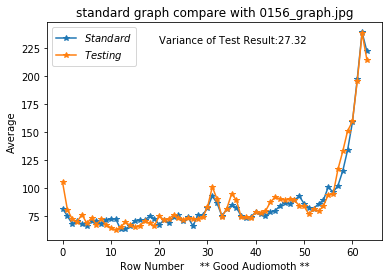

     AM        SD notes
1  0104  MSD-0156  SSFO

MSD-0098
     AM        SD notes
2  0087  MSD-0098  SSFO
 
Variance of Std: 1127.0021314024925
Variance of Test: 1096.3761804103851
In method of ANOVA


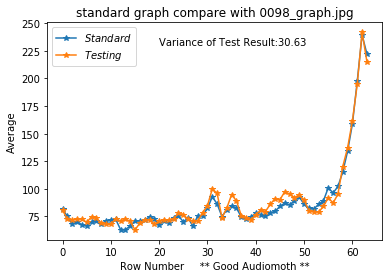

     AM        SD notes
2  0087  MSD-0098  SSFO

MSD-0096
     AM        SD notes
3  0091  MSD-0096  SSFO
 
Variance of Std: 1127.0021314024925
Variance of Test: 1179.8440517783165
In method of ANOVA


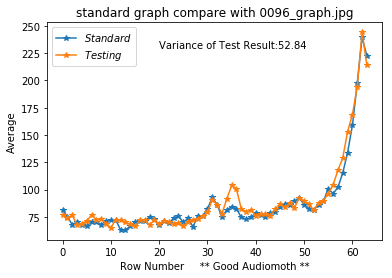

     AM        SD notes
3  0091  MSD-0096  SSFO

MSD-0099
     AM        SD notes
0  0201  MSD-0099  SSFO
 
Variance of Std: 1127.0021314024925
Variance of Test: 1291.3115538954735
In method of ANOVA


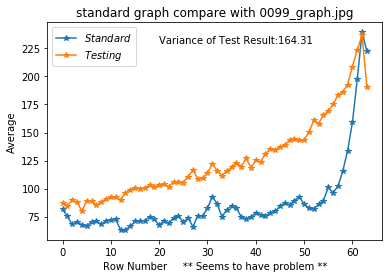

     AM        SD notes
0  0201  MSD-0099  SSFO

MSD-0369
     AM        SD notes
4  0114  MSD-0369  SSFO
 
Variance of Std: 1127.0021314024925
Variance of Test: 1120.8962469100952
In method of ANOVA


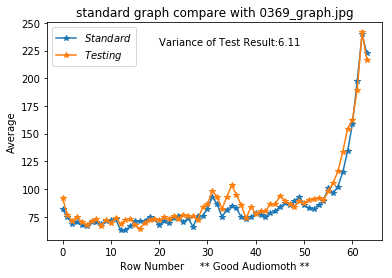

     AM        SD notes
4  0114  MSD-0369  SSFO

MSD-0093
     AM        SD notes
5  0109  MSD-0093  SSFO
 
Variance of Std: 1127.0021314024925
Variance of Test: 1163.0917146205902
In method of ANOVA


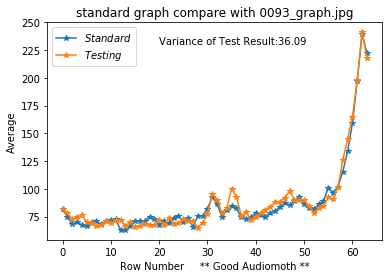

     AM        SD notes
5  0109  MSD-0093  SSFO
         AM        SD BCCH_mean CAWR_mean PIWO_mean notes
0  M11-0104  MSD-0156       827       706       517  SSFO
2  M11-0087  MSD-0098      1490      1164      1548  SSFO
3  M11-0091  MSD-0096      1411      1001      1207  SSFO
4  M11-0201  MSD-0099       130       124       132  SSFO
7  M11-0114  MSD-0369       661       883       737  SSFO
8  M11-0109  MSD-0093      1460      1335      1459  SSFO


In [60]:
sd_prefix = 'MSD'
sd_mount = '/Volumes'

csv_name = "05-23-19-calib_output4.csv"
playback_start = '17:42:45' #'15:38:05'      

calibrate(sd_prefix, sd_mount, playback_start, csv_name)

In [15]:
# save graphs to a larger plot (created to contain the correct number of subplots matching the number of SD cards)
# > pass larger plot to comparingaudio() to add each new graph as a subplot to the larger plot?
# output single megaplot to pdf

0104
